In [2]:
import numpy as np
import colour
import matplotlib.pyplot as plt

In [3]:
M = colour.blindness.matrix_cvd_Machado2009('Deuteranomaly', 1)
s, V = np.linalg.eig(M)

idx = s.argsort()
s = s[idx]
V = V[:,idx]

v = V.T[0]
v = v / np.linalg.norm(v)

print('Eigenvalues:', s)
print('First eigenvector:', v)

Eigenvalues: [  5.73655225e-07   1.00000585e+00   1.00869758e+00]
First eigenvector: [ 0.92205474 -0.38601936  0.02835681]


In [4]:
cube_vertices = [np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), np.array([1, 1, 0]), np.array([1, 0, 1]), np.array([0, 1, 1]), np.array([1, 1, 1])]
center = np.array([1/2, 1/2, 1/2])

max_distance = 0
max_idx = 0
for idx, vertex in enumerate(cube_vertices):
    distance = np.linalg.norm(center + v - vertex)
    if distance > max_distance:
        max_distance = distance
        max_idx = idx
    print(vertex, distance)

anchor_1 = cube_vertices[max_idx]
anchor_2 = np.ones(3) - anchor_1
print(f'Anchor 1: {anchor_1}, Anchor 2: {anchor_2}')

[0 0 0] 1.5213126543
[1 0 0] 0.685771616398
[0 1 0] 1.75682409776
[0 0 1] 1.50255734394
[1 1 0] 1.11459473719
[1 0 1] 0.643093375434
[0 1 1] 1.74060831037
[1 1 1] 1.08885619246
Anchor 1: [0 1 0], Anchor 2: [ 1.  0.  1.]


In [5]:
basis = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

max_scalar = 0
max_idx = 0
for idx, vertex in enumerate(basis):
    if np.abs(np.dot(vertex, v)) > max_scalar:
        max_scalar = np.dot(vertex, v)
        max_idx = idx
    print(vertex, np.abs(np.dot(vertex, v)))

n = basis[max_idx]
e_y, e_z = [basis[i] for i in range(len(basis)) if i != max_idx]
print(f'Normal: {n}, e_y: {e_y}, e_z: {e_z}')

[1 0 0] 0.922054741146
[0 1 0] 0.386019359163
[0 0 1] 0.0283568101653
Normal: [1 0 0], e_y: [0 1 0], e_z: [0 0 1]


In [6]:
d = 1 / np.abs(np.dot(n, v))
d

1.0845343073206231

In [7]:
y = e_y * np.dot(anchor_2 - (anchor_1 + d * v), e_y)
z = e_z * np.dot(anchor_2 - (anchor_1 + d * v), e_z)
print(f'y: {y}, z: {z}')

y: [-0.         -0.58134876 -0.        ], z: [ 0.          0.          0.96924607]


In [8]:
s = 1
for t_y, t_z in ((0,0), (1, 0), (0, 1), (1, 1)):
    x = anchor_1 + d/2 * v + t_y * y + t_z * z
    color_1 = x + s*d/2 *v
    color_2 = x - s*d/2 *v
    print(t_y, t_z)
    print(tuple((255 * color_1).astype(int)), tuple((255 * color_2).astype(int)))
    print(tuple((255 * M@color_1).astype(int)), tuple((255 * M@color_2).astype(int)))

0 0
(255, 148, 7) (0, 255, 0)
(219, 171, 10) (219, 171, 10)
1 0
(255, 0, 7) (0, 106, 0)
(91, 71, 4) (91, 71, 4)
0 1
(255, 148, 255) (0, 255, 247)
(163, 183, 250) (163, 183, 250)
1 1
(255, 0, 255) (0, 106, 247)
(35, 83, 244) (35, 83, 244)


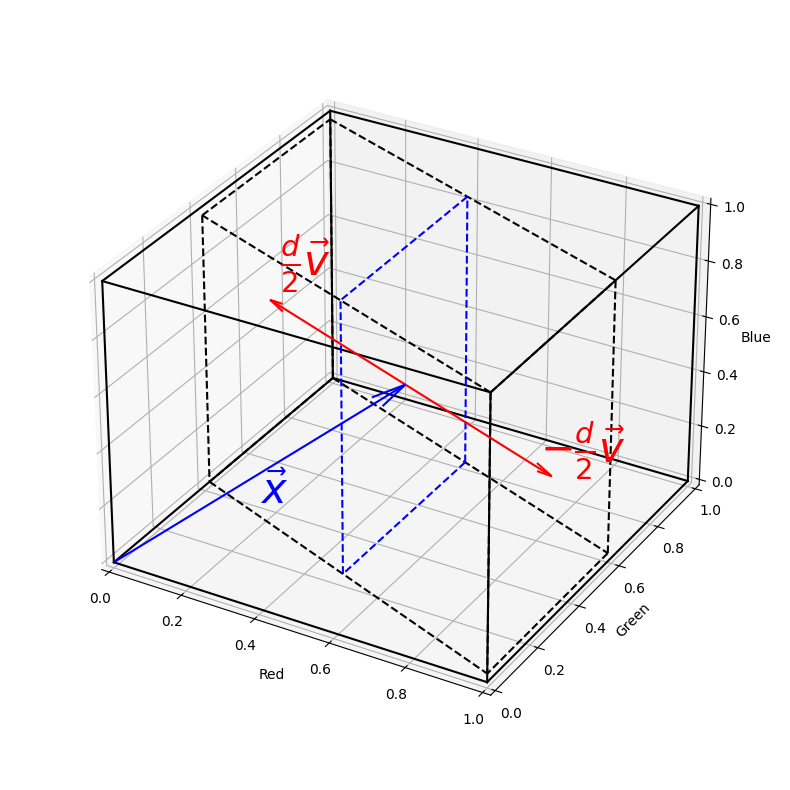

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

cube_vertices = [
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 1, 1]
]

cube_edges = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7]
]

for edge in cube_edges:
    r = [cube_vertices[edge[0]][0], cube_vertices[edge[1]][0]]
    g = [cube_vertices[edge[0]][1], cube_vertices[edge[1]][1]]
    b = [cube_vertices[edge[0]][2], cube_vertices[edge[1]][2]]
    ax.plot(r, g, b, color='black')

parallelepiped_vertices = [
    anchor_1,
    anchor_2,
    anchor_1 + d * v,
    anchor_2 - d * v,
    anchor_1 + y,
    anchor_2 - y,
    anchor_1 + z,
    anchor_2 - z,
    anchor_1 + d * v + y,
    anchor_2 - d * v + y,
    anchor_1 + d * v + z,
    anchor_2 - d * v + z
]

parallelepiped_edges = [
    [0, 2],
    [0, 4], 
    [0, 6],
    [1, 3],
    [1, 5],
    [1, 7],
    [2, 5],
    [2, 7],
    [3, 4],
    [3, 6],
    [4, 7],
    [5, 6]
]

for edge in parallelepiped_edges:
    r = [parallelepiped_vertices[edge[0]][0], parallelepiped_vertices[edge[1]][0]]
    g = [parallelepiped_vertices[edge[0]][1], parallelepiped_vertices[edge[1]][1]]
    b = [parallelepiped_vertices[edge[0]][2], parallelepiped_vertices[edge[1]][2]]
    ax.plot(r, g, b, color='black', linestyle='dashed')

x_area_vertices = [
    anchor_1 + d/2 * v,
    anchor_1 + d/2 * v + y,
    anchor_1 + d/2 * v + z,
    anchor_2 - d/2 * v,
]

x_area_edges = [
    [0, 1],
    [0, 2],
    [1, 3],
    [2, 3]
]

for edge in x_area_edges:
    r = [x_area_vertices[edge[0]][0], x_area_vertices[edge[1]][0]]
    g = [x_area_vertices[edge[0]][1], x_area_vertices[edge[1]][1]]
    b = [x_area_vertices[edge[0]][2], x_area_vertices[edge[1]][2]]
    ax.plot(r, g, b, color='blue', linestyle='dashed')

x = anchor_1 + d/2 * v + 1/2 * y + 1/2 * z
ax.quiver(0, 0, 0, x[0], x[1], x[2], color='blue', arrow_length_ratio=0.1)
c1 = x + d/2 * v
ax.quiver(*x, *(c1-x), color='red', arrow_length_ratio=0.1)
c2 = x - d/2 * v
ax.quiver(*x, *(c2-x), color='red', arrow_length_ratio=0.1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

ax.text(x[0]/2, x[1]/2, x[2]/2 - 0.11, r'$\vec{x}$', color='blue', fontsize=30)
ax.text(x[0] + v[0]/2, x[1] + v[1]/2, x[2] + v[2]/2 + 0.02, r'$-\frac{d}{2}\vec{v}$', color='red', fontsize=30)
ax.text(x[0] - v[0]/2, x[1] - v[1]/2, x[2] - v[2]/2 + 0.11, r'$\frac{d}{2}\vec{v}$', color='red', fontsize=30)

ax.set_box_aspect(aspect=None, zoom=0.9)

plt.show();

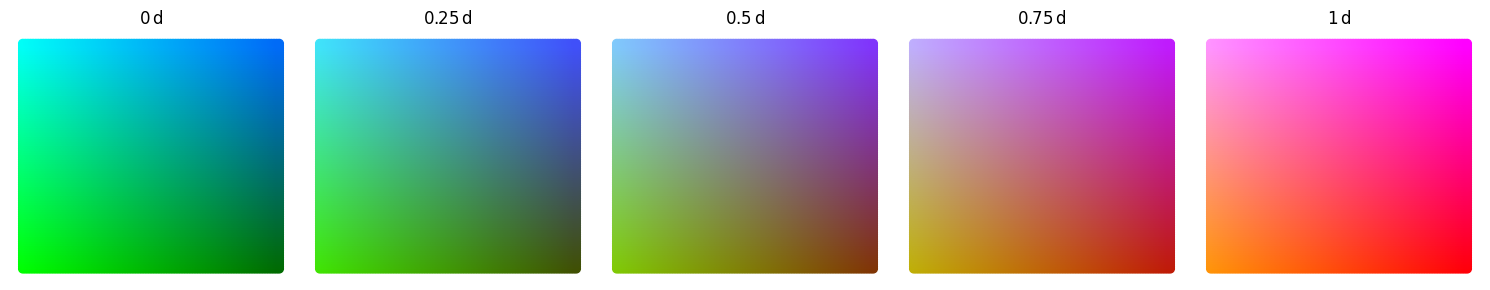

In [10]:
d_vals = np.linspace(0, 1, 5)

grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
color_grid = np.outer(grid[0].reshape(-1), y).reshape(-1, 3) + np.outer(grid[1].reshape(-1), z).reshape(-1, 3)

fig, ax = plt.subplots(1, len(d_vals), figsize=(3*len(d_vals), 3))

for idx, d_val in enumerate(d_vals):
    colors = anchor_1 + d_val * d * v + color_grid
    ax[idx].scatter(grid[0], grid[1], c= colors)
    ax[idx].set_title(f'{d_val:.2g}$\,$d')
    ax[idx].axis('off')

fig.tight_layout()
plt.show()    